## Bar plot for feature importance
This notebook make a horizontal bar plot for the feature importance using ridge regressions' feature coefficients. The feature importance is based on the median value of each feature in the 50 assays. I didn't take the mean value because fr_aniline has a extreme value in one of the assay.

In [ ]:
import random
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# import pymc as pm
# import arviz as az
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

# Set working directory
path = '/content/drive/My Drive/Tox21/hierarchical_model/'

Mounted at /content/drive


In [ ]:
# read feature coefficients
path = '/content/drive/My Drive/Tox21_data/'
# ridge_coef = pd.read_csv(path + 'Unbalanced weight feature coefficients.csv')
# ridge_coef_w = pd.read_csv(path + 'Balanced weight feature coefficients_new2.csv')
# ridge_coef_w = pd.read_csv(path + 'Balanced weight feature coefficients_lasso.csv')
ridge_coef_w = pd.read_csv(path + 'Balanced weight feature coefficients_new_with_new_scaling_method2.csv')
ridge_coef_w

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,240,241,242,243,244,245,246,247,248,249
0,fr_C_O,0.075814,0.124522,13.182387,-0.055210,-0.160134,14.831458,0.088750,-0.086662,2.179118,...,0.051085,5.754538,0.550675,0.343651,0.104969,0.028962,1.123530,1.108924,7.595398,14.755028
1,TPSA,0.002413,-0.483210,-8.107109,-0.128965,0.075388,-9.403467,-0.049469,-0.140908,-0.989410,...,-0.204397,-3.654435,-0.184927,-0.323352,-0.094852,-0.021757,-0.715447,-0.647308,-4.736074,-9.136420
2,SMR_VSA1,0.094965,-0.386451,-12.492897,-0.074747,-0.027667,-14.109624,0.240818,-0.048940,-1.636067,...,0.190724,-5.335948,-0.216286,-0.177011,0.095933,0.062798,-0.949546,-0.869791,-6.818776,-13.854850
3,NumHAcceptors,-0.041848,-0.246019,-7.273549,-0.267757,0.025532,-8.158685,-0.228574,-0.129240,-1.347413,...,-0.033268,-3.199509,-0.291772,-0.161135,-0.096293,-0.164411,-0.698008,-0.772262,-4.873523,-8.106773
4,NumAromaticCarbocycles,-0.133149,-1.361267,-0.048476,0.278149,-0.938369,-0.002024,-0.280994,-0.402421,0.404829,...,-0.718199,0.121340,-0.025520,-0.061204,-0.516322,-0.198518,-0.545740,-0.223114,-0.236052,-0.092286
5,NumHeteroatoms,-0.018665,1.088390,-0.341597,-0.426811,0.754146,-0.160159,-0.071715,0.401446,-0.773627,...,0.240868,-0.271588,-0.150142,0.008518,0.412023,0.292352,0.547051,0.212953,-0.520898,-0.073021
6,Chi4n,-0.092232,0.238633,-0.011533,0.078501,0.710689,0.131248,0.037252,0.243469,0.788827,...,0.462059,0.301519,0.366482,0.396872,0.331086,-0.123557,0.192989,0.041820,1.506115,0.222452
7,VSA_EState10,-0.268995,-0.825797,-0.353453,-0.529725,-0.860793,-0.388047,-0.132086,-0.556757,-0.966531,...,-0.585261,-0.554716,-0.493953,-0.528671,-0.497810,-0.306263,-0.423389,-0.374304,-1.705833,-0.408408
8,VSA_EState3,-0.085984,-0.143077,-0.283119,-0.294566,-0.276028,-0.080003,-0.044023,-0.197227,-0.310792,...,-0.163795,-0.142342,-0.052200,-0.069752,0.239394,-0.121397,-0.173160,-0.096908,-0.477253,-0.312323
9,Kappa1,0.251635,0.762465,0.558231,0.642884,0.643851,0.586794,0.312137,0.655484,1.241532,...,0.994667,0.816152,0.294864,0.977415,0.614729,0.282986,0.493175,0.241662,1.162799,0.847525


In [ ]:
ridge_coef_w = ridge_coef_w.rename(columns = {'Unnamed: 0': 'Features'})
# ridge_coef_w.iloc[:,1:] = abs(ridge_coef_w.iloc[:,1:])
# ridge_coef_w.sort_values(by=['tox21-ahr-p1'], ascending=False)
ridge_coef_w['mean'] = ridge_coef_w.iloc[:,1:].mean(axis=1)
ridge_coef_w

,Features,0,1,2,3,4,5,6,7,8,...,241,242,243,244,245,246,247,248,249,mean
0,fr_C_O,0.075814,0.124522,13.182387,-0.055210,-0.160134,14.831458,0.088750,-0.086662,2.179118,...,5.754538,0.550675,0.343651,0.104969,0.028962,1.123530,1.108924,7.595398,14.755028,2.992364
1,TPSA,0.002413,-0.483210,-8.107109,-0.128965,0.075388,-9.403467,-0.049469,-0.140908,-0.989410,...,-3.654435,-0.184927,-0.323352,-0.094852,-0.021757,-0.715447,-0.647308,-4.736074,-9.136420,-1.800445
2,SMR_VSA1,0.094965,-0.386451,-12.492897,-0.074747,-0.027667,-14.109624,0.240818,-0.048940,-1.636067,...,-5.335948,-0.216286,-0.177011,0.095933,0.062798,-0.949546,-0.869791,-6.818776,-13.854850,-2.605711
3,NumHAcceptors,-0.041848,-0.246019,-7.273549,-0.267757,0.025532,-8.158685,-0.228574,-0.129240,-1.347413,...,-3.199509,-0.291772,-0.161135,-0.096293,-0.164411,-0.698008,-0.772262,-4.873523,-8.106773,-1.758996
4,NumAromaticCarbocycles,-0.133149,-1.361267,-0.048476,0.278149,-0.938369,-0.002024,-0.280994,-0.402421,0.404829,...,0.121340,-0.025520,-0.061204,-0.516322,-0.198518,-0.545740,-0.223114,-0.236052,-0.092286,-0.261101
5,NumHeteroatoms,-0.018665,1.088390,-0.341597,-0.426811,0.754146,-0.160159,-0.071715,0.401446,-0.773627,...,-0.271588,-0.150142,0.008518,0.412023,0.292352,0.547051,0.212953,-0.520898,-0.073021,0.058877
6,Chi4n,-0.092232,0.238633,-0.011533,0.078501,0.710689,0.131248,0.037252,0.243469,0.788827,...,0.301519,0.366482,0.396872,0.331086,-0.123557,0.192989,0.041820,1.506115,0.222452,0.222190
7,VSA_EState10,-0.268995,-0.825797,-0.353453,-0.529725,-0.860793,-0.388047,-0.132086,-0.556757,-0.966531,...,-0.554716,-0.493953,-0.528671,-0.497810,-0.306263,-0.423389,-0.374304,-1.705833,-0.408408,-0.466843
8,VSA_EState3,-0.085984,-0.143077,-0.283119,-0.294566,-0.276028,-0.080003,-0.044023,-0.197227,-0.310792,...,-0.142342,-0.052200,-0.069752,0.239394,-0.121397,-0.173160,-0.096908,-0.477253,-0.312323,-0.079969
9,Kappa1,0.251635,0.762465,0.558231,0.642884,0.643851,0.586794,0.312137,0.655484,1.241532,...,0.816152,0.294864,0.977415,0.614729,0.282986,0.493175,0.241662,1.162799,0.847525,0.706604


In [ ]:
categories = []
for i in ridge_coef_w.Features:
  if i.startswith('fr_'):
    categories.append('Fraction of a substructure')
  elif i.startswith('PEOE'):
    categories.append('MOE type - Partial Charges')
  elif i.startswith('SlogP'):
    categories.append('MOE type - LogP')
  elif i.startswith('SMR'):
    categories.append('MOE type - MR')
  elif i.startswith('EState') or i.startswith('VSA'):
    categories.append('MOE type - EState')
  elif i.startswith('BCUT2D'):
    categories.append('BCUT type')
  else:
    categories.append('physicochemical properties')
ridge_coef_w['category'] = categories
ridge_coef_w

,Features,0,1,2,3,4,5,6,7,8,...,242,243,244,245,246,247,248,249,mean,category
0,fr_C_O,0.075814,0.124522,13.182387,-0.055210,-0.160134,14.831458,0.088750,-0.086662,2.179118,...,0.550675,0.343651,0.104969,0.028962,1.123530,1.108924,7.595398,14.755028,2.992364,Fraction of a substructure
1,TPSA,0.002413,-0.483210,-8.107109,-0.128965,0.075388,-9.403467,-0.049469,-0.140908,-0.989410,...,-0.184927,-0.323352,-0.094852,-0.021757,-0.715447,-0.647308,-4.736074,-9.136420,-1.800445,physicochemical properties
2,SMR_VSA1,0.094965,-0.386451,-12.492897,-0.074747,-0.027667,-14.109624,0.240818,-0.048940,-1.636067,...,-0.216286,-0.177011,0.095933,0.062798,-0.949546,-0.869791,-6.818776,-13.854850,-2.605711,MOE type - MR
3,NumHAcceptors,-0.041848,-0.246019,-7.273549,-0.267757,0.025532,-8.158685,-0.228574,-0.129240,-1.347413,...,-0.291772,-0.161135,-0.096293,-0.164411,-0.698008,-0.772262,-4.873523,-8.106773,-1.758996,physicochemical properties
4,NumAromaticCarbocycles,-0.133149,-1.361267,-0.048476,0.278149,-0.938369,-0.002024,-0.280994,-0.402421,0.404829,...,-0.025520,-0.061204,-0.516322,-0.198518,-0.545740,-0.223114,-0.236052,-0.092286,-0.261101,physicochemical properties
5,NumHeteroatoms,-0.018665,1.088390,-0.341597,-0.426811,0.754146,-0.160159,-0.071715,0.401446,-0.773627,...,-0.150142,0.008518,0.412023,0.292352,0.547051,0.212953,-0.520898,-0.073021,0.058877,physicochemical properties
6,Chi4n,-0.092232,0.238633,-0.011533,0.078501,0.710689,0.131248,0.037252,0.243469,0.788827,...,0.366482,0.396872,0.331086,-0.123557,0.192989,0.041820,1.506115,0.222452,0.222190,physicochemical properties
7,VSA_EState10,-0.268995,-0.825797,-0.353453,-0.529725,-0.860793,-0.388047,-0.132086,-0.556757,-0.966531,...,-0.493953,-0.528671,-0.497810,-0.306263,-0.423389,-0.374304,-1.705833,-0.408408,-0.466843,MOE type - EState
8,VSA_EState3,-0.085984,-0.143077,-0.283119,-0.294566,-0.276028,-0.080003,-0.044023,-0.197227,-0.310792,...,-0.052200,-0.069752,0.239394,-0.121397,-0.173160,-0.096908,-0.477253,-0.312323,-0.079969,MOE type - EState
9,Kappa1,0.251635,0.762465,0.558231,0.642884,0.643851,0.586794,0.312137,0.655484,1.241532,...,0.294864,0.977415,0.614729,0.282986,0.493175,0.241662,1.162799,0.847525,0.706604,physicochemical properties


In [ ]:
from scipy.stats import sem
ridge_coef_w['std'] = sem(ridge_coef_w.iloc[:,1:252], axis=1)
ridge_coef_w['std_np'] = np.std(ridge_coef_w.iloc[:,1:252], axis=1)
coef_plot = ridge_coef_w[['Features', 'mean', 'category', 'std', 'std_np']]
coef_plot = coef_plot.sort_values(by=['mean'])
coef_plot

,Features,mean,category,std,std_np
2,SMR_VSA1,-2.605711,MOE type - MR,0.428500,6.775173
1,TPSA,-1.800445,physicochemical properties,0.275623,4.357990
3,NumHAcceptors,-1.758996,physicochemical properties,0.249571,3.946068
37,BalabanJ,-0.654493,physicochemical properties,0.023929,0.378348
21,fr_phenol_noOrthoHbond,-0.590317,Fraction of a substructure,0.031624,0.500015
31,MinAbsPartialCharge,-0.540751,physicochemical properties,0.023948,0.378647
7,VSA_EState10,-0.466843,MOE type - EState,0.019102,0.302022
18,BCUT2D_LOGPLOW,-0.355290,BCUT type,0.021728,0.343551
36,fr_Al_OH_noTert,-0.280773,Fraction of a substructure,0.017320,0.273856
22,SlogP_VSA1,-0.271729,MOE type - LogP,0.039120,0.618537


In [ ]:
coef_plot.to_csv(path + 'Ridge_Feature_imp_DS1.csv', index=False)

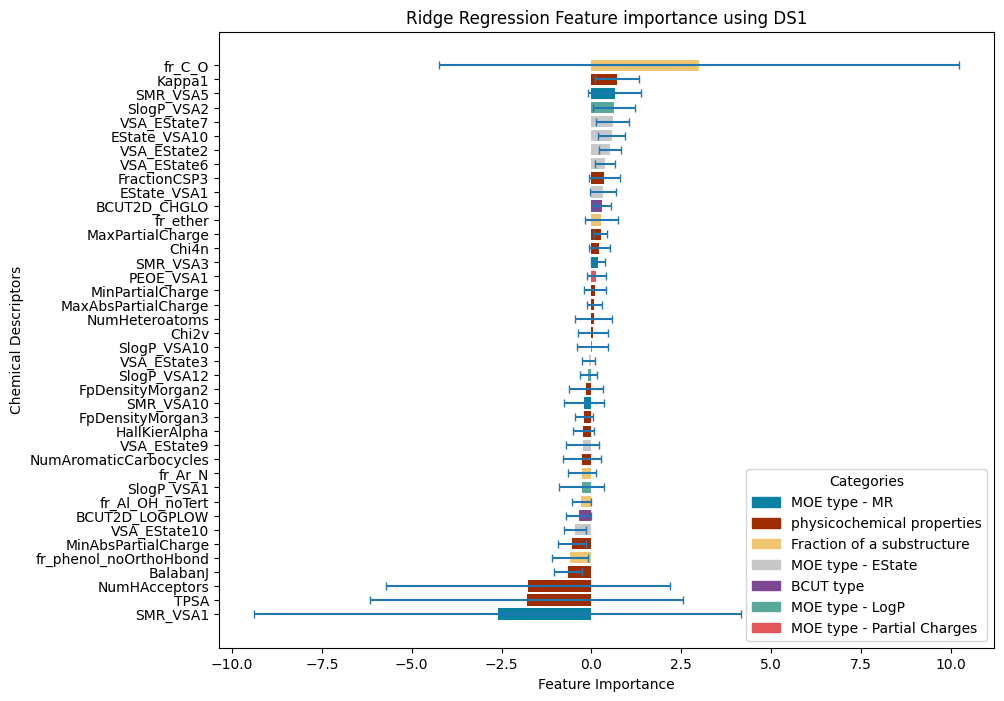

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
colors = {'MOE type - EState': '#c8c8c8', 'Fraction of a substructure': '#f0c571', 'MOE type - LogP': '#59a89c',
          'MOE type - MR':'#0b81a2', 'MOE type - Partial Charges': '#e25759',
          'physicochemical properties': '#9d2c00', 'BCUT type': '#7E4794'}
plt.barh(data = coef_plot, y='Features', width='mean', color=[colors[i] for i in coef_plot.category])
plt.errorbar(data = coef_plot, y='Features', x='mean', xerr = 'std_np', fmt ='none', capsize=3)

labels = coef_plot['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Categories")
plt.title('Ridge Regression Feature importance using DS1')
plt.xlabel('Feature Importance')
plt.ylabel('Chemical Descriptors')
# plt.savefig(path + 'lasso_new.png', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
coef_plot.to_csv(path + 'ridge_feature_ranking.csv', index=False)

In [ ]:
# Boxplot
# plt.boxplot(ridge_coef_w.iloc[:,1:51].T)

In [ ]:
#Feature Importance for NB
# feature_top_40 = ['Chi4v', 'SMR_VSA4', 'EState_VSA5', 'SlogP_VSA10', 'EState_VSA8',
#                   'Kappa3', 'fr_Al_COO', 'SlogP_VSA8', 'PEOE_VSA10', 'fr_amide',
#                   'PEOE_VSA14', 'VSA_EState10', 'FractionCSP3', 'PEOE_VSA4',
#                   'VSA_EState9', 'VSA_EState3', 'MolLogP', 'VSA_EState7', 'BalabanJ',
#                   'fr_ketone_Topliss', 'fr_methoxy', 'MaxAbsPartialCharge',
#                   'MinAbsPartialCharge', 'FpDensityMorgan3', 'BCUT2D_MWHI',
#                   'MinAbsEStateIndex', 'fr_ester', 'fr_bicyclic', 'SlogP_VSA3',
#                   'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'fr_aniline', 'fr_para_hydroxylation',
#                   'EState_VSA2', 'VSA_EState4', 'EState_VSA9', 'PEOE_VSA9', 'SlogP_VSA1',
#                   'SlogP_VSA12', 'TPSA']

# feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
                  # 'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
                  # 'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
                  # 'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
                  # 'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
                  # 'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
                  # 'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
                  # 'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
                  # 'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO']

imp_score = np.load(path + 'imp_score.npy')
imp_score

array([[ 0.00000000e+00, -1.60857909e-03,  4.28954424e-03, ...,
         8.04289544e-04,  0.00000000e+00,  3.21715818e-03],
       [ 2.47933884e-03,  9.09090909e-03,  1.48760331e-02, ...,
         9.09090909e-03,  4.95867769e-03,  1.11570248e-02],
       [-9.00900901e-04, -2.02702703e-03,  6.30630631e-03, ...,
        -6.66133815e-17, -9.00900901e-04,  5.85585586e-03],
       ...,
       [ 6.56934307e-04,  9.48905109e-04,  1.45985401e-04, ...,
         1.16788321e-03,  7.29927007e-05,  4.37956204e-04],
       [ 7.45614035e-03, -2.19298246e-03, -2.19298246e-03, ...,
         8.77192982e-04,  3.94736842e-03,  0.00000000e+00],
       [ 2.85326087e-03, -1.22282609e-03, -4.07608696e-04, ...,
        -2.71739130e-03, -1.49456522e-03,  2.98913043e-03]])

In [ ]:
from scipy.stats import sem
v = np.array([sum(x)/len(x) for x in zip(*imp_score)])
v_std = np.array([sem(x) for x in zip(*imp_score)])

In [ ]:
print(v)
print(v_std)

[ 1.40669631e-03 -4.53006812e-04  1.19538336e-03  1.32620938e-03
  4.51719219e-03  2.21166771e-03 -5.63145063e-04 -1.35606951e-03
 -6.32984305e-04  4.40134470e-03  2.00155499e-03  5.02620470e-04
  1.97189055e-03 -2.13156338e-03 -1.86964123e-03  3.44564143e-03
 -3.10812157e-04  9.31355380e-04 -2.96503255e-04  1.23425011e-03
  1.55650474e-03 -2.45999426e-03  1.64522815e-05  7.21000326e-05
 -1.54666898e-04  1.08951524e-03 -8.76075932e-05  1.64091174e-03
  1.84348396e-03  1.43164841e-03 -1.52023708e-04  1.02822619e-03
  2.66175713e-03 -1.03276407e-03 -6.27406757e-04  4.69485954e-04
  6.12802745e-05  2.18897461e-03  6.03408227e-04  4.14723402e-03]
[0.00019313 0.0002114  0.00025852 0.00019441 0.00037256 0.00031201
 0.00030276 0.00025015 0.00036649 0.00047299 0.00044725 0.00031315
 0.00043717 0.00026032 0.0002798  0.00033841 0.0001911  0.00026551
 0.00023754 0.00030158 0.00022713 0.00021645 0.00019897 0.00025614
 0.00023624 0.00017995 0.00017527 0.00025203 0.00032177 0.00022964
 0.00016669 0.

In [ ]:
imp = pd.DataFrame(v, columns=['imp_score'])
imp['features'] = ridge_coef_w.Features
imp['std'] = v_std
imp['category'] = coef_plot.category
imp = imp.sort_values(by=['imp_score'])
imp

,imp_score,features,std,category
21,-0.002460,fr_phenol_noOrthoHbond,0.000216,Fraction of a substructure
13,-0.002132,HallKierAlpha,0.000260,physicochemical properties
14,-0.001870,SMR_VSA5,0.000280,MOE type - MR
7,-0.001356,VSA_EState10,0.000250,MOE type - EState
33,-0.001033,SMR_VSA3,0.000227,MOE type - MR
8,-0.000633,VSA_EState3,0.000366,MOE type - EState
34,-0.000627,FpDensityMorgan3,0.000292,physicochemical properties
6,-0.000563,Chi4n,0.000303,physicochemical properties
1,-0.000453,TPSA,0.000211,physicochemical properties
16,-0.000311,FractionCSP3,0.000191,physicochemical properties


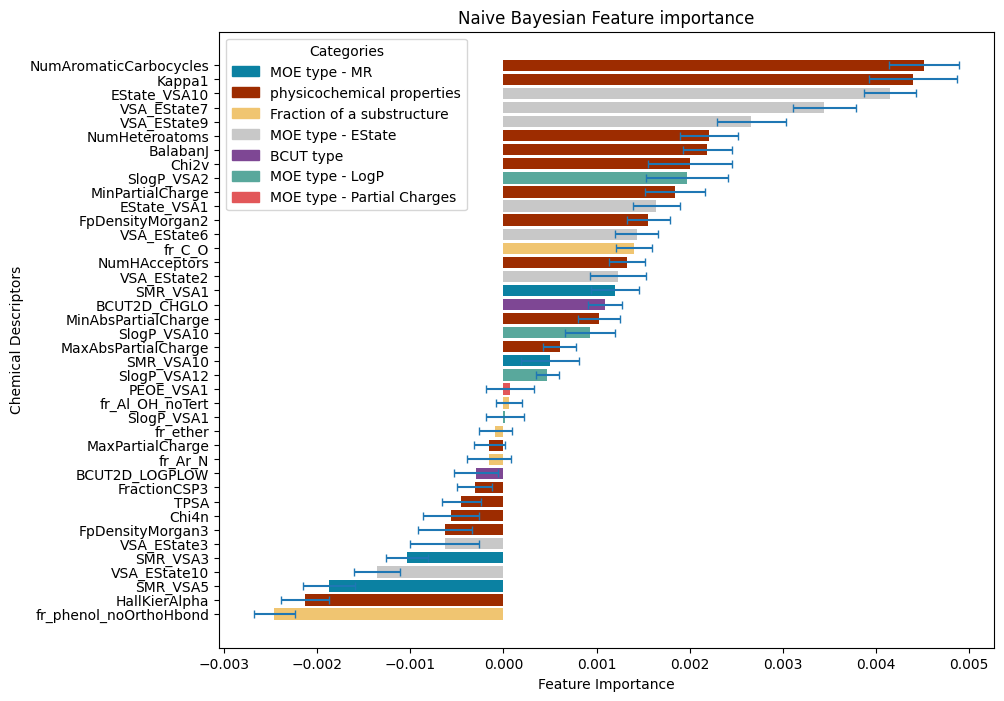

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
colors = {'MOE type - EState': '#c8c8c8', 'Fraction of a substructure': '#f0c571', 'MOE type - LogP': '#59a89c',
          'MOE type - MR':'#0b81a2', 'MOE type - Partial Charges': '#e25759',
          'physicochemical properties': '#9d2c00', 'BCUT type': '#7E4794', 'assay_meta_info': '36b700'}
plt.barh(data = imp, y='features', width='imp_score', color=[colors[i] for i in imp.category])
plt.errorbar(data = imp, y='features', x='imp_score', xerr = 'std', fmt ='none', capsize=3)

labels = coef_plot['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Categories")
plt.title('Naive Bayesian Feature importance')
plt.xlabel('Feature Importance')
plt.ylabel('Chemical Descriptors')
plt.savefig(path + 'nbfi_new.png', dpi=300, bbox_inches='tight')
plt.show()

### Hierarchical Model Coefficient

### Histogram for model performance

In [ ]:
df_err = {'Model': ['Ridge Regression', 'Naive Bayesian', 'Hierarchical Bayesian'],
      'Training': [0.018, 0.016, np.nan],
      'Testing': [0.026, 0.025, np.nan]}
df_err = pd.DataFrame(df_err)
df = {'Model': ['Ridge Regression', 'Naive Bayesian', 'Hierarchical Bayesian'],
      'Training': [0.7674, 0.6835, np.nan],
      'Testing': [0.7537, 0.6787, np.nan]}
df = pd.DataFrame(df)
df

,Model,Training,Testing
0,Ridge Regression,0.7674,0.7537
1,Naive Bayesian,0.6835,0.6787
2,Hierarchical Bayesian,NaN,NaN


In [ ]:
tidy_err = df_err.melt(id_vars='Model').rename(columns=str.title)
tidy_err = tidy_err.rename(columns = {'Variable':'Dataset'})
tidy_err

,Model,Dataset,Value
0,Ridge Regression,Training,0.018
1,Naive Bayesian,Training,0.016
2,Hierarchical Bayesian,Training,NaN
3,Ridge Regression,Testing,0.026
4,Naive Bayesian,Testing,0.025
5,Hierarchical Bayesian,Testing,NaN


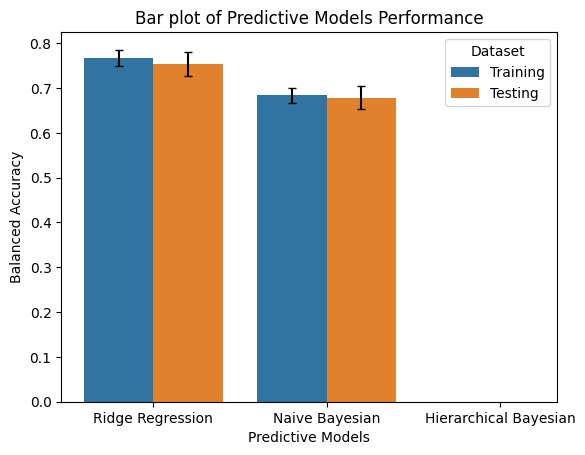

In [ ]:
tidy = df.melt(id_vars='Model').rename(columns=str.title)
tidy = tidy.rename(columns = {'Variable':'Dataset'})
ax = sns.barplot(x='Model', y='Value', hue='Dataset', data=tidy)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=tidy_err["Value"], fmt="none", c="k", capsize=3)
plt.ylabel('Balanced Accuracy')
plt.xlabel('Predictive Models')
plt.title('Bar plot of Predictive Models Performance')
plt.savefig(path + 'model_performance.png', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
# Box plot
nb_bal = pd.read_csv(path + 'nb_bal_acc_80_20.csv')
nb_bal_t = pd.read_csv(path + 'nb_bal_acc_t_80_20.csv')
nb_auc = pd.read_csv(path + 'nb_auc_80_20.csv')
nb_auc_t = pd.read_csv(path + 'nb_auc_t_80_20.csv')

In [ ]:
lg_bal = pd.read_csv(path + 'lg_bal_acc_80_20.csv')
lg_bal_t = pd.read_csv(path + 'lg_bal_acc_t_80_20.csv')
lg_auc = pd.read_csv(path + 'lg_auc_80_20.csv')
lg_auc_t = pd.read_csv(path + 'lg_auc_t_80_20.csv')

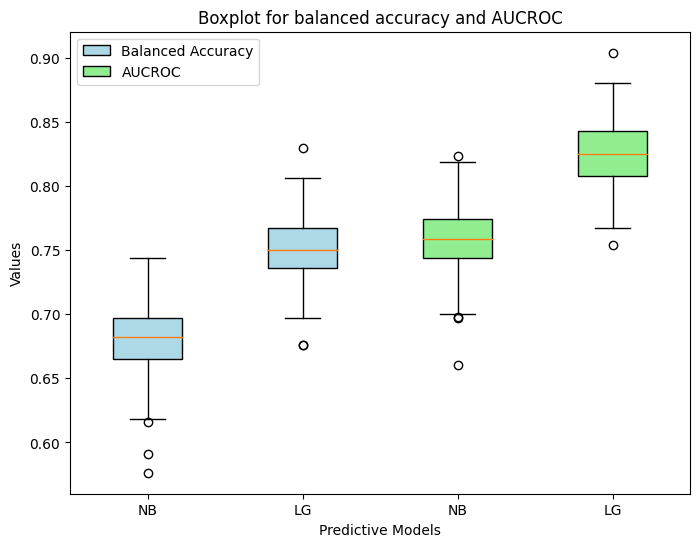

In [ ]:
# plt.boxplot([nb_bal['0'].tolist(), lg_bal['0'].tolist(), nb_auc['0'].tolist(), lg_auc['0'].tolist()])
# plt.title('Boxplot for balanced accuracy and AUCROC')
# plt.xticks([1, 2, 3, 4], ["NB Balanced Accuracy","LG Balanced Accuracy", "NB AUCROC score", "LG AUCROC score"])
labels = ['NB', 'LG', 'NB', 'LG']
fig, ax1 = plt.subplots(figsize=(8, 6))
bplot1 = ax1.boxplot([nb_bal['0'].tolist(), lg_bal['0'].tolist(), nb_auc['0'].tolist(), lg_auc['0'].tolist()],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Boxplot for balanced accuracy and AUCROC')

colors = ['lightblue', 'lightblue', 'lightgreen', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
  patch.set_facecolor(color)

ax1.legend([bplot1["boxes"][0],bplot1["boxes"][2]], ['Balanced Accuracy', 'AUCROC'], loc='upper left')
plt.xlabel('Predictive Models')
plt.ylabel('Values')
plt.show()

In [ ]:
path = '/content/drive/My Drive/Tox21_data/'

In [ ]:
xls = pd.ExcelFile(path + 'Tox21/assay_list.xls')
# to read just one sheet to dataframe:
df = []
for i in range(len(xls.sheet_names)):
    df1 = xls.parse(i)
    df.append(df1)

xls2 = pd.ExcelFile(path + 'Tox21/assay_list2.xls')

for i in range(len(xls2.sheet_names)):
    df1 = xls2.parse(i)
    df.append(df1)

len(df)


50

In [ ]:
unimp_fea = pd.read_csv(path + 'unimportant_features_Tox21_with90cutoff.csv')
unimp_fea = list(unimp_fea.unimp_fea)
# unimp_fea
lasso_fea_114 = pd.read_csv(path + '114_feature_ranked_by_lasso.csv')
lasso_fea_114 = list(lasso_fea_114['0'])
lasso_fea_114

['fr_C_O',
 'TPSA',
 'NumAromaticCarbocycles',
 'SMR_VSA1',
 'NumHAcceptors',
 'VSA_EState10',
 'SlogP_VSA10',
 'Chi2v',
 'VSA_EState3',
 'fr_phenol_noOrthoHbond',
 'Chi4n',
 'FractionCSP3',
 'Kappa1',
 'BCUT2D_LOGPLOW',
 'fr_Ar_N',
 'NumHeteroatoms',
 'VSA_EState7',
 'SMR_VSA10',
 'BCUT2D_CHGLO',
 'SMR_VSA5',
 'HallKierAlpha',
 'fr_ether',
 'PEOE_VSA1',
 'SMR_VSA3',
 'SlogP_VSA2',
 'EState_VSA1',
 'MolLogP',
 'fr_C_O_noCOO',
 'VSA_EState9',
 'SlogP_VSA12',
 'FpDensityMorgan2',
 'fr_ester',
 'SlogP_VSA1',
 'BalabanJ',
 'EState_VSA10',
 'BCUT2D_MRHI',
 'PEOE_VSA14',
 'VSA_EState6',
 'SMR_VSA4',
 'BCUT2D_CHGHI',
 'fr_Al_OH_noTert',
 'MinPartialCharge',
 'FpDensityMorgan3',
 'SlogP_VSA3',
 'MinEStateIndex',
 'fr_imidazole',
 'VSA_EState2',
 'VSA_EState1',
 'FpDensityMorgan1',
 'MinAbsPartialCharge',
 'fr_NH2',
 'EState_VSA8',
 'VSA_EState4',
 'MinAbsEStateIndex',
 'BCUT2D_MWHI',
 'fr_NH1',
 'MaxAbsEStateIndex',
 'fr_methoxy',
 'SMR_VSA7',
 'NumAliphaticHeterocycles',
 'SlogP_VSA11',
 'Kap

In [ ]:
label_encoder = preprocessing.LabelEncoder()
# coefs = []
coefs_w = []
# bal_accs = []
bal_accs_w = []
# auc_scores = []
auc_scores_w = []
f1_scores = []
recall_scores = []
precision_scores = []
bal_accs_t = []
auc_scores_t = []
scores = []
cd_dfs = []
coef_df_w = []

# feature_top_40 = ['Chi4v', 'SMR_VSA4', 'EState_VSA5', 'SlogP_VSA10', 'EState_VSA8',
#                   'Kappa3', 'fr_Al_COO', 'SlogP_VSA8', 'PEOE_VSA10', 'fr_amide',
#                   'PEOE_VSA14', 'VSA_EState10', 'FractionCSP3', 'PEOE_VSA4',
#                   'VSA_EState9', 'VSA_EState3', 'MolLogP', 'VSA_EState7', 'BalabanJ',
#                   'fr_ketone_Topliss', 'fr_methoxy', 'MaxAbsPartialCharge',
#                   'MinAbsPartialCharge', 'FpDensityMorgan3', 'BCUT2D_MWHI',
#                   'MinAbsEStateIndex', 'fr_ester', 'fr_bicyclic', 'SlogP_VSA3',
#                   'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'fr_aniline', 'fr_para_hydroxylation',
#                   'EState_VSA2', 'VSA_EState4', 'EState_VSA9', 'PEOE_VSA9', 'SlogP_VSA1',
#                   'SlogP_VSA12', 'TPSA']

feature_top_40 = ['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
                  'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
                  'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
                  'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
                  'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
                  'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
                  'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
                  'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
                  'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO']

cv = KFold(n_splits=5, random_state=1, shuffle=True)
for j in [5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 114]:
  for i in range(len(df)):
    one_assay = df[i]
    one_assay = one_assay.drop(one_assay.columns[0],axis=1).drop_duplicates(subset = 'SMILES')
    y = label_encoder.fit_transform(one_assay.iloc[:,0])
    # X = one_assay.drop(columns = unimp_fea)
    # X = X.drop(X.columns[[0,1]], axis=1)
    # print(X.columns)
    X = one_assay[one_assay.columns.intersection(lasso_fea_114[:j])]
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # logistic_cv_balanced = LogisticRegressionCV(penalty='l1',class_weight='balanced', solver = 'saga').fit(X_train, y_train)
    # lg = LogisticRegressionCV(penalty='l2',Cs=10,max_iter=10000,class_weight='balanced')
    lg = LogisticRegressionCV(penalty='l1',class_weight='balanced', solver='saga')
    logistic_cv_balanced = lg.fit(X_train, y_train)
    coef_w = logistic_cv_balanced.coef_[0]
    coef_w_df = pd.DataFrame({'features': list(X.columns), 'coefs': list(coef_w)}, columns=['features', 'coefs'])
    coefs_w.append(coef_w)
    coef_df_w.append(coef_w_df)


  # evaluate model
    score = cross_val_score(logistic_cv_balanced, X_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    scores.append(score)

    y_train_pred = logistic_cv_balanced.predict(X_train)
    y_pred_balanced = logistic_cv_balanced.predict(X_test)
    y_train_pred_prob = logistic_cv_balanced.predict_proba(X_train)[:,1]
    y_pred_prob_bal = logistic_cv_balanced.predict_proba(X_test)[:,1]

    cd_df = pd.DataFrame({'y_true': list(y_test), 'y_pred': list(y_pred_prob_bal), 'assay_name': one_assay.columns[0]},
                        columns=['y_true', 'y_pred', 'assay_name'])
    cd_dfs.append(cd_df)

    bal_acc_w = balanced_accuracy_score(y_test,y_pred_balanced)
    bal_acc_t = balanced_accuracy_score(y_train,y_train_pred)

    auc_score_w = metrics.roc_auc_score(y_test, y_pred_prob_bal)
    auc_score_t = metrics.roc_auc_score(y_train, y_train_pred_prob)

    recall_score = metrics.recall_score(y_test, y_pred_balanced)
    f1_score = metrics.f1_score(y_test, y_pred_balanced)
    precision_score = metrics.precision_score(y_test, y_pred_balanced)

    bal_accs_w.append(bal_acc_w)
    auc_scores_w.append(auc_score_w)
    recall_scores.append(recall_score)
    f1_scores.append(f1_score)
    precision_scores.append(precision_score)
    bal_accs_t.append(bal_acc_t)
    auc_scores_t.append(auc_score_t)
  print(j)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which me

5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

15


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

20


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

25


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

30


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

40


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

60


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [ ]:
len(scores)

NameError: ignored

In [ ]:
pd.DataFrame(scores).to_csv(path + 'scores_CD_plot.csv_2', index=False)

In [ ]:
scores = pd.read_csv(path + 'scores_CD_plot.csv')
scores

,0,1,2,3,4
0,0.680414,0.714236,0.664876,0.697046,0.747621
1,0.594252,0.639520,0.626039,0.601422,0.636202
2,0.633610,0.640911,0.641686,0.623568,0.637952
3,0.667872,0.705946,0.670098,0.693352,0.643836
4,0.646664,0.620416,0.665857,0.621878,0.672453
...,...,...,...,...,...
545,0.749629,0.752143,0.774687,0.750720,0.770014
546,0.742143,0.746061,0.740716,0.775757,0.742962
547,0.755814,0.729286,0.731164,0.734040,0.731967
548,0.803406,0.739903,0.763975,0.746799,0.748377


In [ ]:
df_fea_40 = scores.iloc[300:350,:]
df_fea_40.to_csv(path+ 'fea_40_bal_acc.csv', index=False)

In [ ]:
df_fea_60 = scores.iloc[350:400,:]
df_fea_60.to_csv(path+ 'fea_60_bal_acc.csv', index=False)

In [ ]:
df_fea_80 = scores.iloc[400:450,:]
df_fea_80.to_csv(path+ 'fea_80_bal_acc.csv', index=False)

In [ ]:
df_fea_100 = scores.iloc[450:500,:]
df_fea_100.to_csv(path+ 'fea_100_bal_acc.csv', index=False)

In [ ]:
df_fea_114 = scores.iloc[500:,:]
df_fea_114.to_csv(path+ 'fea_114_bal_acc.csv', index=False)

In [ ]:
scores_df = pd.DataFrame(scores)
features = scores_df.iloc[:, :].to_numpy().tolist()

In [ ]:
new_df = pd.DataFrame({
    "bal_acc_40": features
})
new_df

,bal_acc_40
0,"[0.7481586116436283, 0.7490058108998141, 0.782..."
1,"[0.7451471034273582, 0.7667388380408753, 0.742..."
2,"[0.6888263193339925, 0.7260624679979519, 0.751..."
3,"[0.7360072412155745, 0.8070221257902068, 0.765..."
4,"[0.7029547402358894, 0.7377822972316659, 0.738..."
5,"[0.8000466304435974, 0.760287021889043, 0.7670..."
6,"[0.7635676944887471, 0.7905313864217973, 0.695..."
7,"[0.7030307968062571, 0.7039309954751132, 0.727..."
8,"[0.7606821884690177, 0.7057751017639078, 0.767..."
9,"[0.773079644879053, 0.7416568396226415, 0.6991..."


In [ ]:
new_df['bal_acc_80'] = features
new_df

,bal_acc_40,bal_acc_60,bal_acc_107,bal_acc_80
0,"[0.7481586116436283, 0.7490058108998141, 0.782...","[0.7654289846298725, 0.726087355248568, 0.7915...","[0.7608969831500353, 0.7385553619515286, 0.762...","[0.7638314330878149, 0.7459044411281649, 0.759..."
1,"[0.7451471034273582, 0.7667388380408753, 0.742...","[0.732332423415226, 0.7844126234294525, 0.7556...","[0.7670609645131938, 0.7883984515959715, 0.763...","[0.7524264482863209, 0.7469327165961356, 0.754..."
2,"[0.6888263193339925, 0.7260624679979519, 0.751...","[0.6950880511255355, 0.7006912442396314, 0.728...","[0.7151377724283197, 0.719610855094726, 0.7442...","[0.6963991459972202, 0.7130568356374808, 0.729..."
3,"[0.7360072412155745, 0.8070221257902068, 0.765...","[0.7181156517094017, 0.7885995928426015, 0.775...","[0.7417052469135803, 0.8024884817314903, 0.773...","[0.7369569088319088, 0.8044171220400729, 0.766..."
4,"[0.7029547402358894, 0.7377822972316659, 0.738...","[0.730816634697792, 0.7373421563865954, 0.7259...","[0.6936946496347386, 0.7230906993686256, 0.731...","[0.7126923233889728, 0.7309221709567751, 0.747..."
5,"[0.8000466304435974, 0.760287021889043, 0.7670...","[0.8003760846646663, 0.74019963138603, 0.78145...","[0.7611659638309951, 0.7638747955020813, 0.782...","[0.7796660854756305, 0.7585060779887759, 0.775..."
6,"[0.7635676944887471, 0.7905313864217973, 0.695...","[0.7772018429913167, 0.7823272617793166, 0.702...","[0.7499335459861776, 0.7956495559235285, 0.708...","[0.7499335459861776, 0.8065256661147072, 0.725..."
7,"[0.7030307968062571, 0.7039309954751132, 0.727...","[0.6846654174135027, 0.6994555995475114, 0.724...","[0.6966521373092174, 0.7062287895927601, 0.724...","[0.701696675900277, 0.7143806561085972, 0.7312..."
8,"[0.7606821884690177, 0.7057751017639078, 0.767...","[0.7108013174261137, 0.7013483717774762, 0.783...","[0.7413500113873268, 0.7328188602442334, 0.787...","[0.7338475149349171, 0.7293249660786973, 0.789..."
9,"[0.773079644879053, 0.7416568396226415, 0.6991...","[0.7670162120432321, 0.7250884433962264, 0.701...","[0.7476839938239835, 0.7440153301886793, 0.701...","[0.779722079258878, 0.7337116745283019, 0.7047..."


In [ ]:
new_df.to_csv(path+'CD_plot_bac_acc.csv')

In [ ]:
np.mean(bal_accs_w)

0.755662638883374

In [ ]:
np.mean(bal_accs_w)

0.756259886806713

In [ ]:
dffs = pd.concat(cd_dfs)
dffs

,y_true,y_pred,assay_name
0,0,0.169121,tox21-ahr-p1
1,0,0.342172,tox21-ahr-p1
2,0,0.284583,tox21-ahr-p1
3,0,0.656562,tox21-ahr-p1
4,0,0.316805,tox21-ahr-p1
...,...,...,...
1418,0,0.058703,tox21-rt-viability-hek293-p1
1419,0,0.141152,tox21-rt-viability-hek293-p1
1420,0,0.531301,tox21-rt-viability-hek293-p1
1421,0,0.224806,tox21-rt-viability-hek293-p1


In [ ]:
cd_plot = pd.read_csv(path + 'CD_plot_data.csv')
cd_plot['y_pred_40_new'] = dffs.y_pred.values
cd_plot.to_csv(path + 'CD_plot_data.csv')

In [ ]:
# dff = pd.concat(cd_dfs)
dff['y_pred_60'] = dffs.y_pred
dff

,y_true,y_pred,assay_name,y_pred_60
0,0,0.160815,tox21-ahr-p1,0.058443
1,0,0.334021,tox21-ahr-p1,0.176292
2,0,0.404516,tox21-ahr-p1,0.129218
3,0,0.623878,tox21-ahr-p1,0.623585
4,0,0.315137,tox21-ahr-p1,0.217767
...,...,...,...,...
1418,0,0.090927,tox21-rt-viability-hek293-p1,0.055014
1419,0,0.208029,tox21-rt-viability-hek293-p1,0.140969
1420,0,0.598098,tox21-rt-viability-hek293-p1,0.546384
1421,0,0.259326,tox21-rt-viability-hek293-p1,0.201033


In [ ]:
dff = dff.rename(columns={"y_pred": "y_pred_40"})
dff.iloc[50:100]

,y_true,y_pred_40,assay_name,y_pred_60
50,0,0.780905,tox21-ahr-p1,0.580657
51,0,0.826335,tox21-ahr-p1,0.896320
52,0,0.646822,tox21-ahr-p1,0.653850
53,0,0.210266,tox21-ahr-p1,0.131950
54,0,0.464607,tox21-ahr-p1,0.451172
55,0,0.217748,tox21-ahr-p1,0.081049
56,0,0.468191,tox21-ahr-p1,0.520069
57,0,0.377689,tox21-ahr-p1,0.269764
58,0,0.043852,tox21-ahr-p1,0.015527
59,0,0.723126,tox21-ahr-p1,0.609779


In [ ]:
# dff.to_csv(path+'CD_plot_data.csv')
dffs.iloc[50:100]

,y_true,y_pred,assay_name
50,0,0.580657,tox21-ahr-p1
51,0,0.896320,tox21-ahr-p1
52,0,0.653850,tox21-ahr-p1
53,0,0.131950,tox21-ahr-p1
54,0,0.451172,tox21-ahr-p1
55,0,0.081049,tox21-ahr-p1
56,0,0.520069,tox21-ahr-p1
57,0,0.269764,tox21-ahr-p1
58,0,0.015527,tox21-ahr-p1
59,0,0.609779,tox21-ahr-p1


In [ ]:
coefs_w_df = pd.DataFrame(coefs_w).T
fea_name = one_assay.drop(columns = unimp_fea).columns
fea_name = fea_name[2:]
assay_name = []
for i in range(len(df)):
    one_assay = df[i]
    y = one_assay.columns[1]
    assay_name.append(y)
len(assay_name)
# assay_name

50

In [ ]:
coefs_w_df.columns = assay_name
coefs_w_df = coefs_w_df.set_axis(fea_name, axis=0)

In [ ]:
coefs_w_df = abs(coefs_w_df)
coefs_w_df['mean'] = coefs_w_df.mean(axis=1)
coefs_w_df = coefs_w_df.sort_values(by=['mean'], ascending=False)
coefs_w_df

,tox21-ahr-p1,tox21-ap1-agonist-p1,tox21-ar-bla-antagonist-p1,tox21-ar-mda-kb2-luc-agonist-p3,tox21-ar-mda-kb2-luc-antagonist-p1,tox21-ar-mda-kb2-luc-antagonist-p2,tox21-are-bla-p1,tox21-aromatase-p1,tox21-car-agonist-p1,tox21-car-antagonist-p1,...,tox21-shh-3t3-gli3-agonist-p1,tox21-shh-3t3-gli3-antagonist-p1,tox21-vdr-bla-agonist-p1,tox21-vdr-bla-antagonist-p1,tox21-dt40-p1_653,tox21-dt40-p1_100,tox21-dt40-p1_657,tox21-rt-viability-hepg2-p1,tox21-rt-viability-hek293-p1,mean
VSA_EState3,0.788010,0.852876,7.293622e-01,0.563587,0.742802,0.556397,0.532658,1.200210,0.0,0.664646,...,0.977148,0.855545,0.162490,0.796333,0.664873,0.664062,0.832157,0.954277,0.576630,0.598156
TPSA,0.398595,0.658091,2.591818e-01,0.150076,0.506013,0.474323,0.503036,0.618657,0.0,1.036821,...,0.476425,0.583520,0.107578,0.571035,0.664706,0.712567,0.759756,1.698457,0.434296,0.549723
SlogP_VSA10,1.115721,0.502546,5.237067e-01,0.824941,1.351124,0.989162,0.069616,0.844024,0.0,0.896498,...,0.596238,0.578884,0.237293,0.493723,0.892573,0.646140,0.831057,0.036874,0.639380,0.543128
FractionCSP3,0.653706,0.517780,2.970416e-01,0.705307,0.531355,0.603767,0.588223,0.347294,0.0,0.602944,...,0.390545,0.219373,0.299134,0.479453,0.383195,0.268726,0.414367,0.605668,0.280300,0.487749
SlogP_VSA1,0.379847,0.739768,1.642158e-01,0.249151,0.315677,0.432655,0.730111,0.312215,0.0,0.635554,...,0.687377,0.669319,0.052487,0.550572,0.267910,0.072155,0.201445,0.036261,0.298306,0.419295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PEOE_VSA12,0.091046,0.260731,1.869992e-08,0.111511,0.111530,0.103618,0.115124,0.048555,0.0,0.032167,...,0.003379,0.010913,0.000000,0.182159,0.005187,0.153265,0.027204,0.012612,0.010059,0.071816
Ipc,0.109970,0.076159,1.019218e-01,0.059586,0.081384,0.125822,0.107522,0.017479,0.0,0.078852,...,0.000127,0.000078,0.141808,0.037294,0.120958,0.016843,0.116540,0.097021,0.055960,0.066279
MaxPartialCharge,0.119366,0.032142,0.000000e+00,0.018910,0.079230,0.075903,0.170904,0.083864,0.0,0.047085,...,0.099818,0.024138,0.000000,0.092042,0.036545,0.007195,0.090629,0.088460,0.006939,0.065404
fr_para_hydroxylation,0.000978,0.056809,4.019547e-02,0.015288,0.004811,0.110657,0.087916,0.056647,0.0,0.034066,...,0.007017,0.086572,0.000000,0.016706,0.016825,0.037898,0.032488,0.037035,0.000245,0.058283


In [ ]:
coefs_w_df.head(40).index

Index(['FractionCSP3', 'VSA_EState3', 'SlogP_VSA10', 'PEOE_VSA14', 'fr_Al_COO',
       'MolLogP', 'SlogP_VSA3', 'VSA_EState9', 'VSA_EState7', 'BCUT2D_LOGPLOW',
       'qed', 'MinAbsEStateIndex', 'SlogP_VSA1', 'VSA_EState10',
       'FpDensityMorgan3', 'fr_methoxy', 'MaxAbsPartialCharge', 'BCUT2D_MWHI',
       'fr_ester', 'BCUT2D_MRHI', 'fr_NH1', 'fr_C_O_noCOO',
       'MinAbsPartialCharge', 'MinPartialCharge', 'VSA_EState5', 'TPSA',
       'SlogP_VSA8', 'SlogP_VSA6', 'fr_NH0', 'PEOE_VSA10', 'SlogP_VSA2',
       'fr_Al_OH_noTert', 'BalabanJ', 'Chi4v', 'VSA_EState1', 'VSA_EState4',
       'SMR_VSA4', 'fr_Ar_N', 'EState_VSA8', 'BCUT2D_CHGLO'],
      dtype='object')

In [ ]:
list(set(feature_top_40) -set(coefs_w_df.head(40).index))

['EState_VSA2',
 'EState_VSA5',
 'fr_bicyclic',
 'PEOE_VSA4',
 'fr_ketone_Topliss',
 'fr_para_hydroxylation',
 'SlogP_VSA12',
 'EState_VSA9',
 'fr_amide',
 'PEOE_VSA9',
 'Kappa3',
 'fr_aniline']

In [ ]:
fea_0 = []
fea_n0 = []
for i in range(len(coef_df_w)):
    co = list(coef_df_w[i][coef_df_w[i].coefs==0].features)
    cos = list(coef_df_w[i][coef_df_w[i].coefs!=0].features)
    if co != None:
        fea_0.append(co)
        fea_n0.append(cos)


In [ ]:
flat_list = [item for sublist in fea_n0 for item in sublist]
flat_list = pd.DataFrame(flat_list, columns=['features'])
flat_list

,features
0,MinEStateIndex
1,MaxAbsEStateIndex
2,MinAbsEStateIndex
3,qed
4,MaxPartialCharge
...,...
4802,fr_ketone
4803,fr_ketone_Topliss
4804,fr_methoxy
4805,fr_para_hydroxylation


In [ ]:
lasso_fea = pd.DataFrame(flat_list.value_counts(), columns=['count']).reset_index()
lasso_fea

,features,count
0,Chi4v,48
1,qed,47
2,FractionCSP3,47
3,MaxAbsPartialCharge,47
4,MinAbsEStateIndex,47
...,...,...
102,BCUT2D_CHGLO,42
103,RingCount,42
104,BCUT2D_CHGHI,42
105,Kappa1,41


In [ ]:
list(set(feature_top_40) - set(coefs_w_df.head(40).index))

['EState_VSA2',
 'fr_bicyclic',
 'BalabanJ',
 'EState_VSA9',
 'FpDensityMorgan3',
 'EState_VSA5',
 'PEOE_VSA4',
 'fr_ketone_Topliss',
 'fr_methoxy',
 'fr_aniline',
 'EState_VSA8',
 'PEOE_VSA9',
 'Kappa3',
 'fr_para_hydroxylation',
 'SlogP_VSA12',
 'MinAbsEStateIndex',
 'PEOE_VSA10',
 'SMR_VSA4',
 'MaxAbsPartialCharge',
 'Chi4v']

In [ ]:
lasso_fea['coef'] = coefs_w_df['mean'].values
lasso_fea['mean_coef'] = coefs_w_df.index
lasso_fea

,features,count,coef,mean_coef
0,Chi4v,48,0.598156,VSA_EState3
1,qed,47,0.549723,TPSA
2,FractionCSP3,47,0.543128,SlogP_VSA10
3,MaxAbsPartialCharge,47,0.487749,FractionCSP3
4,MinAbsEStateIndex,47,0.419295,SlogP_VSA1
...,...,...,...,...
102,BCUT2D_CHGLO,42,0.071816,PEOE_VSA12
103,RingCount,42,0.066279,Ipc
104,BCUT2D_CHGHI,42,0.065404,MaxPartialCharge
105,Kappa1,41,0.058283,fr_para_hydroxylation


In [ ]:
lasso_fea.to_csv(path + 'feature_imp_lasso.csv')

In [ ]:
feature_top_80 = lasso_fea.head(80).mean_coef.values

In [ ]:
lasso_ff = lasso_fea[~lasso_fea.mean_coef.isin(feature_top_40)]
lasso_ff

,features,count,coef,mean_coef
6,MinAbsPartialCharge,50,0.423366,Chi4n
10,PEOE_VSA10,50,0.349797,SlogP_VSA2
11,fr_C_O_noCOO,50,0.348109,BCUT2D_CHGLO
12,FractionCSP3,50,0.340789,SlogP_VSA11
13,SlogP_VSA8,50,0.336617,HallKierAlpha
...,...,...,...,...
100,SlogP_VSA5,46,0.080821,Kappa2
102,RingCount,46,0.079445,PEOE_VSA5
103,VSA_EState6,46,0.077763,PEOE_VSA12
104,BertzCT,45,0.077624,EState_VSA3


In [ ]:
lasso_ff.head(20).mean_coef

6                      Chi4n
10                SlogP_VSA2
11              BCUT2D_CHGLO
12               SlogP_VSA11
13             HallKierAlpha
15                SlogP_VSA6
17           fr_Al_OH_noTert
18               VSA_EState5
21                 RingCount
24                  SMR_VSA1
25                    fr_NH0
26                    fr_NH1
27               VSA_EState1
28               VSA_EState6
30                  SMR_VSA3
31                   fr_Ar_N
32                fr_halogen
34               EState_VSA1
37                 NHOHCount
39    NumAromaticCarbocycles
Name: mean_coef, dtype: object

In [ ]:
feature_top_60 = []
feature_top_60 = list(feature_top_40) + list(lasso_ff.head(20).mean_coef.values)
feature_top_60

['Chi4v',
 'SMR_VSA4',
 'EState_VSA5',
 'SlogP_VSA10',
 'EState_VSA8',
 'Kappa3',
 'fr_Al_COO',
 'SlogP_VSA8',
 'PEOE_VSA10',
 'fr_amide',
 'PEOE_VSA14',
 'VSA_EState10',
 'FractionCSP3',
 'PEOE_VSA4',
 'VSA_EState9',
 'VSA_EState3',
 'MolLogP',
 'VSA_EState7',
 'BalabanJ',
 'fr_ketone_Topliss',
 'fr_methoxy',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'MinAbsEStateIndex',
 'fr_ester',
 'fr_bicyclic',
 'SlogP_VSA3',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'fr_aniline',
 'fr_para_hydroxylation',
 'EState_VSA2',
 'VSA_EState4',
 'EState_VSA9',
 'PEOE_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA12',
 'TPSA',
 'Chi4n',
 'SlogP_VSA2',
 'BCUT2D_CHGLO',
 'SlogP_VSA11',
 'HallKierAlpha',
 'SlogP_VSA6',
 'fr_Al_OH_noTert',
 'VSA_EState5',
 'RingCount',
 'SMR_VSA1',
 'fr_NH0',
 'fr_NH1',
 'VSA_EState1',
 'VSA_EState6',
 'SMR_VSA3',
 'fr_Ar_N',
 'fr_halogen',
 'EState_VSA1',
 'NHOHCount',
 'NumAromaticCarbocycles']

In [ ]:
feature_top_40 = ['Chi4v', 'SMR_VSA4', 'EState_VSA5', 'SlogP_VSA10', 'EState_VSA8',
                  'Kappa3', 'fr_Al_COO', 'SlogP_VSA8', 'PEOE_VSA10', 'fr_amide',
                  'PEOE_VSA14', 'VSA_EState10', 'FractionCSP3', 'PEOE_VSA4',
                  'VSA_EState9', 'VSA_EState3', 'MolLogP', 'VSA_EState7', 'BalabanJ',
                  'fr_ketone_Topliss', 'fr_methoxy', 'MaxAbsPartialCharge',
                  'MinAbsPartialCharge', 'FpDensityMorgan3', 'BCUT2D_MWHI',
                  'MinAbsEStateIndex', 'fr_ester', 'fr_bicyclic', 'SlogP_VSA3',
                  'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'fr_aniline', 'fr_para_hydroxylation',
                  'EState_VSA2', 'VSA_EState4', 'EState_VSA9', 'PEOE_VSA9', 'SlogP_VSA1',
                  'SlogP_VSA12', 'TPSA']

In [ ]:
feature_top_60 = ['Chi4v',
 'SMR_VSA4',
 'EState_VSA5',
 'SlogP_VSA10',
 'EState_VSA8',
 'Kappa3',
 'fr_Al_COO',
 'SlogP_VSA8',
 'PEOE_VSA10',
 'fr_amide',
 'PEOE_VSA14',
 'VSA_EState10',
 'FractionCSP3',
 'PEOE_VSA4',
 'VSA_EState9',
 'VSA_EState3',
 'MolLogP',
 'VSA_EState7',
 'BalabanJ',
 'fr_ketone_Topliss',
 'fr_methoxy',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'MinAbsEStateIndex',
 'fr_ester',
 'fr_bicyclic',
 'SlogP_VSA3',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'fr_aniline',
 'fr_para_hydroxylation',
 'EState_VSA2',
 'VSA_EState4',
 'EState_VSA9',
 'PEOE_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA12',
 'TPSA',
 'Chi4n',
 'SlogP_VSA2',
 'BCUT2D_CHGLO',
 'SlogP_VSA11',
 'HallKierAlpha',
 'SlogP_VSA6',
 'fr_Al_OH_noTert',
 'VSA_EState5',
 'RingCount',
 'SMR_VSA1',
 'fr_NH0',
 'fr_NH1',
 'VSA_EState1',
 'VSA_EState6',
 'SMR_VSA3',
 'fr_Ar_N',
 'fr_halogen',
 'EState_VSA1',
 'NHOHCount',
 'NumAromaticCarbocycles']

In [ ]:
assay_info_train = pd.read_csv(path+'assay_info_train_rescale.csv')
assay_info_train

,ProtocolName,Cell_Line,Tissue_Type4,Cell_Type,Gender,Organism,Tissue_Type2
0,tox21-ar-mda-kb2-luc-antagonist-p2,MDA-MB-453,Metastatic,epithelial,F,Human,pericardial effusion
1,tox21-fxr-bla-agonist-p2,HEK293,Normal,epithelial,F,Human,kidney
2,tox21-er-luc-bg1-4e2-antagonist-p2,BG1,Primary,epithelial,F,Human,ovary
3,tox21-pr-bla-antagonist-p1,HEK293,Normal,epithelial,F,Human,kidney
4,tox21-dt40-p1_653,DT40,Primary,lymphoblast,F,Animal cell,bursa
...,...,...,...,...,...,...,...
287656,tox21-p53-bla-p1,HCT-116,Primary,epithelial,M,Human,colon
287657,tox21-vdr-bla-antagonist-p1,HEK293,Normal,epithelial,F,Human,kidney
287658,tox21-nfkb-bla-agonist-p1,ME-180,Metastatic,epithelial,F,Human,omentum
287659,tox21-ahr-p1,HepG2,Primary,epithelial-like,M,Human,liver


In [ ]:
assay_info_train.Gender.value_counts()

F    227993
M     59668
Name: Gender, dtype: int64

In [ ]:
assay_info_train.Organism.value_counts()

Human          235934
Animal cell     51727
Name: Organism, dtype: int64

In [ ]:
assay_info_test = pd.read_csv(path+'assay_info_test.csv')
assay_info_test

,ProtocolName,Cell_Line,Tissue_Type4,Cell_Type,Gender,Organism,Tissue_Type2
0,tox21-pgc-err-p1,HEK293,Normal,epithelial,F,Human,kidney
1,tox21-ap1-agonist-p1,ME-180,Metastatic,epithelial,F,Human,omentum
2,tox21-ppard-bla-agonist-p1,HEK293,Normal,epithelial,F,Human,kidney
3,tox21-sbe-bla-antagonist-p1,HEK293,Normal,epithelial,F,Human,kidney
4,tox21-dt40-p1_657,DT40,Primary,lymphoblast,F,Animal cell,bursa
...,...,...,...,...,...,...,...
71911,tox21-p53-bla-p1,HCT-116,Primary,epithelial,M,Human,colon
71912,tox21-gr-hela-bla-antagonist-p1,HeLa,Primary,epithelial,F,Human,uterus; cervix
71913,tox21-ppard-bla-agonist-p1,HEK293,Normal,epithelial,F,Human,kidney
71914,tox21-shh-3t3-gli3-antagonist-p1,NIH/3T3,Normal,fibroblast,M,Animal cell,connective tissue


In [ ]:
assay_info_test.Gender.value_counts()

F              55598
M              14886
Unspecified     1432
Name: Gender, dtype: int64

In [ ]:
assay_info_test.Organism.value_counts()

Human          58942
Animal cell    12974
Name: Organism, dtype: int64

In [ ]:
X_train = pd.read_csv(path + 'resampled_data/X_train_resampled_80_20.csv')
X_train.Gender.value_counts()

0    46786
1    10572
Name: Gender, dtype: int64

In [ ]:
X_train.Organism.value_counts()

1    43312
0    14046
Name: Organism, dtype: int64

In [ ]:
X_test = pd.read_csv(path + 'resampled_data/X_test_80_20.csv')
X_test.Gender.value_counts()

0    56999
1    14917
Name: Gender, dtype: int64

In [ ]:
X_test.Organism.value_counts()

1    58984
0    12932
Name: Organism, dtype: int64